# What are the most optimal skills to learn as a Data Analyst in the United States?

#### Methodology
1. Group skills to determine median salary and liklihood of being in a job posting
1. Visualize median salary vs percent skill demand
1. Determine if certain technologies are more prevalent

In [18]:
# Import Libraries
import ast
import pandas as pd
from datasets import load_dataset
import matplotlib.pyplot as plt
import seaborn as sns

# Loading Data
dataset = load_dataset('lukebarousse/data_jobs')
df = dataset['train'].to_pandas()

# Data Cleanup
df['job_posted_date'] = pd.to_datetime(df['job_posted_date'])
df['job_skills'] = df['job_skills'].apply(lambda x: ast.literal_eval(x) if pd.notna(x) else x)

In [19]:
df_DA_US = df[(df['job_country'] == 'United States') & (df['job_title'] == 'Data Analyst')].copy()

In [20]:
# Drop NaN values from the 'salary_year_avg' column for accurate visualization
df_DA_US = df_DA_US.dropna(subset=['salary_year_avg'])

df_DA_US_exploded = df_DA_US.explode('job_skills')

df_DA_US_exploded[['salary_year_avg', 'job_skills']].head(5)

,salary_year_avg,job_skills
1681,111175.0,sql
1681,111175.0,tableau
1681,111175.0,power bi
1681,111175.0,excel
3237,120000.0,sql


In [21]:
df_DA_skills = df_DA_US_exploded.groupby('job_skills')['salary_year_avg'].agg(['count', 'median']).sort_values(by='count', ascending=False)

df_DA_skills = df_DA_skills.rename(columns={'count': 'skill_count', 'median': 'median_salary'})

DA_job_count = len(df_DA_US)  # Find count of Data Analyst jobs in US with salary info

df_DA_skills['skill_percent'] = df_DA_skills['skill_count'] / DA_job_count * 100

df_DA_skills = df_DA_skills[df_DA_skills['skill_count'] > 0]

df_DA_skills

,skill_count,median_salary,skill_percent
job_skills,,,
sql,714,87500.0,63.864043
excel,472,77500.0,42.218247
python,408,90000.0,36.493739
tableau,398,90000.0,35.599284
power bi,279,87500.0,24.955277
...,...,...,...
django,1,82500.0,0.089445
bitbucket,1,111175.0,0.089445
node,1,65000.0,0.089445


In [23]:
skill_limit = 5

df_DA_skills_high_demand = df_DA_skills[df_DA_skills['skill_percent'] > skill_limit]

df_DA_skills_high_demand

,skill_count,median_salary,skill_percent
job_skills,,,
sql,714,87500.0,63.864043
excel,472,77500.0,42.218247
python,408,90000.0,36.493739
tableau,398,90000.0,35.599284
power bi,279,87500.0,24.955277
r,244,90000.0,21.824687
sas,200,84078.5,17.889088
powerpoint,102,77500.0,9.123435
word,89,75000.0,7.960644


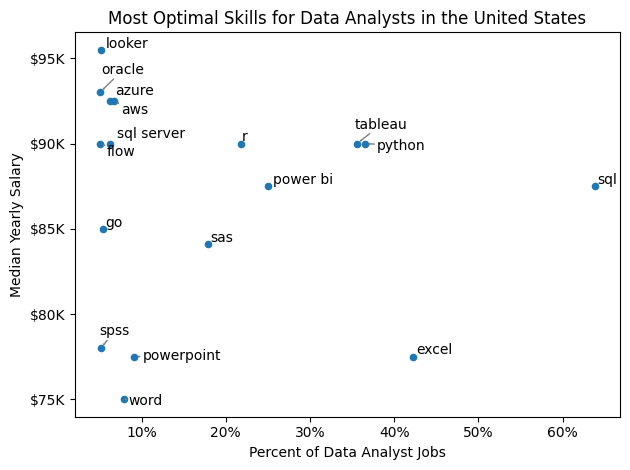

In [30]:
from adjustText import adjust_text

df_DA_skills_high_demand.plot(kind='scatter', x='skill_percent', y='median_salary')

# Prepare texts for adjustText
texts = []
for i, txt in enumerate(df_DA_skills_high_demand.index):
    texts.append(plt.text(df_DA_skills_high_demand['skill_percent'].iloc[i], df_DA_skills_high_demand['median_salary'].iloc[i], txt))

# Adjust text to avoid overlap
adjust_text(texts, arrowprops=dict(arrowstyle='->', color='gray'))

# Set axis labels, title, and legend
plt.xlabel('Percent of Data Analyst Jobs')
plt.ylabel('Median Yearly Salary')
plt.title(f'Most Optimal Skills for Data Analysts in the United States')

from matplotlib.ticker import PercentFormatter
ax = plt.gca()
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'${int(x/1000)}K'))
ax.xaxis.set_major_formatter(PercentFormatter(decimals=0))

# Adjust layout and display plot 
plt.tight_layout()
plt.show()

In [32]:
df_technology = df['job_type_skills'].copy()

# remove duplicates
df_technology = df_technology.drop_duplicates()

# remove NaN values
df_technology = df_technology.dropna()

# combine all dictionaries into one
technology_dict = {}
for row in df_technology:
    row_dict = ast.literal_eval(row)  # convert string to dictionary
    for key, value in row_dict.items():
        if key in technology_dict:  # if key already exists in technology_dict, add value to existing value
            technology_dict[key] += value
        else:                       # if key does not exist in technology_dict, add key and value
            technology_dict[key] = value

# remove duplicates by converting values to set then back to list
for key, value in technology_dict.items():
    technology_dict[key] = list(set(value))

In [33]:
# turn dictionary into dataframe
df_technology = pd.DataFrame(list(technology_dict.items()), columns=['technology', 'skills'])

df_technology = df_technology.explode('skills')

df_technology

,technology,skills
0,analyst_tools,splunk
0,analyst_tools,excel
0,analyst_tools,outlook
0,analyst_tools,visio
0,analyst_tools,qlik
...,...,...
9,sync,mattermost
9,sync,twilio
9,sync,zoom
9,sync,unify


In [34]:
# merge df_DA_skills and df_technology
df_DA_skills_tech = df_DA_skills.merge(df_technology, left_on='job_skills', right_on='skills')

df_DA_skills_tech

,skill_count,median_salary,skill_percent,technology,skills
0,714,87500.0,63.864043,programming,sql
1,472,77500.0,42.218247,analyst_tools,excel
2,408,90000.0,36.493739,programming,python
3,398,90000.0,35.599284,analyst_tools,tableau
4,279,87500.0,24.955277,analyst_tools,power bi
...,...,...,...,...,...
142,1,82500.0,0.089445,webframeworks,django
143,1,111175.0,0.089445,other,bitbucket
144,1,65000.0,0.089445,webframeworks,node
145,1,83500.0,0.089445,webframeworks,node.js


In [35]:
df_DA_skills_tech_high_demand = df_DA_skills_tech[df_DA_skills_tech['skill_percent'] > skill_limit]

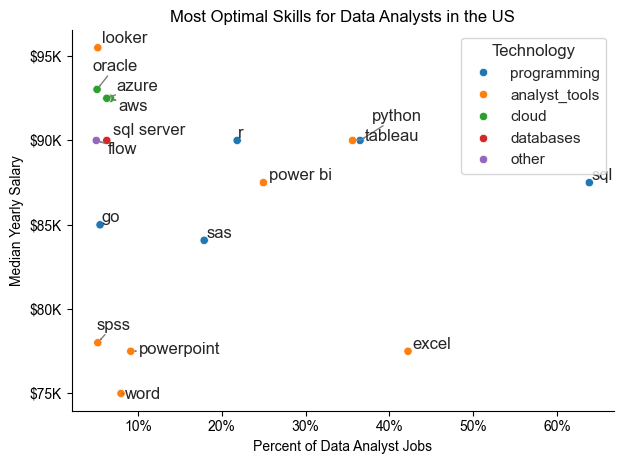

In [36]:
sns.scatterplot(
    data=df_DA_skills_tech_high_demand,
    x='skill_percent',
    y='median_salary',
    hue='technology'
)

sns.despine()
sns.set_theme(style='ticks')

# Prepare texts for adjustText
texts = []
for i, txt in enumerate(df_DA_skills_high_demand.index):
    texts.append(plt.text(df_DA_skills_high_demand['skill_percent'].iloc[i], df_DA_skills_high_demand['median_salary'].iloc[i], txt))

# Adjust text to avoid overlap
adjust_text(texts, arrowprops=dict(arrowstyle='->', color='gray'))

# Set axis labels, title, and legend
plt.xlabel('Percent of Data Analyst Jobs')
plt.ylabel('Median Yearly Salary')
plt.title('Most Optimal Skills for Data Analysts in the US')
plt.legend(title='Technology')

from matplotlib.ticker import PercentFormatter
ax = plt.gca()
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, pos: f'${int(y/1000)}K'))
ax.xaxis.set_major_formatter(PercentFormatter(decimals=0))

# Adjust layout and display plot 
plt.tight_layout()
plt.show()